## Imports

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report, multilabel_confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import pickle
import ast

In [2]:
import sys
sys.path.append('..')

In [3]:

from src.models.tune_utils import tune_hyperparams_optuna, tune_hyperparams_rand
from src.models.train_predict import evaluate_ml, train_evaluate
from src.features.build_features import split_transform_data

In [5]:
from dotenv import load_dotenv
import os
load_dotenv()
SEED=int(os.getenv('SEED'))

## Data processing for multiclasss case

Now I'll clean and lemmatize the reviews.

In [7]:
#df_mlt_class = pd.read_csv(r'C:\Users\user\Desktop\plot_project\data\processed\data_processed')
df_mlt_class = pd.read_csv('../data/processed/data_processed.csv')

In [11]:
df_mlt_class['Plot'] = df_mlt_class['Plot'].apply(ast.literal_eval)

After text preprocessing is more or less finished, it's time to encode the target and vectorize the texts.

In [12]:
encoder = OrdinalEncoder()
labels = df_mlt_class['Genre'].unique()
df_mlt_class['Genre'] = encoder.fit_transform(df_mlt_class['Genre'].to_numpy().reshape(-1, 1))

In [14]:
df_mlt_class.tail()

,Unnamed: 0,index,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
25986,25986,34875,2011,Once Upon a Time in Anatolia,Turkish,Nuri Bilge Ceylan,"Yılmaz Erdoğan, Taner Birsel & Ufuk Karaali",53.0,https://en.wikipedia.org/wiki/Once_Upon_a_Time...,"[night, three, car, carry, small, group, men, ..."
25987,25987,34876,2013,Selam,Turkish,Levent Demirkale,"Bucin Abdullah, Selma Alispahic, Tina Cvitanov...",53.0,https://en.wikipedia.org/wiki/Selam_(film),"[film, open, senegalese, boy, named, khadim, t..."
25988,25988,34882,2017,Çalgı Çengi İkimiz,Turkish,Selçuk Aydemir,"Ahmet Kural, Murat Cemcir",26.0,https://en.wikipedia.org/wiki/%C3%87alg%C4%B1_...,"[two, musician, salih, gürkan, described, adve..."
25989,25989,34883,2017,Olanlar Oldu,Turkish,Hakan Algül,"Ata Demirer, Tuvana Türkay, Ülkü Duru",26.0,https://en.wikipedia.org/wiki/Olanlar_Oldu,"[zafer, sailor, living, mother, döndü, coastal..."
25990,25990,34884,2017,Non-Transferable,Turkish,Brendan Bradley,"YouTubers Shanna Malcolm, Shira Lazar, Sara Fl...",104.0,https://en.wikipedia.org/wiki/Non-Transferable...,"[film, centre, around, young, woman, named, am..."


I see that plots are sorted by origin and so last ones are all Turkish so I'll shuffle the instances before splitting.

# Creation, evaluation and saving models

## Embedding and splitting of data

In [15]:
vectorizer_lemm = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
X_train, X_test, y_train, y_test = split_transform_data(df_mlt_class.Plot, df_mlt_class.Genre, vectorizer_lemm)

## Baseline Bayes

In [47]:
bayes = MultinomialNB()

In [48]:
baseline_bayes = train_evaluate(bayes, X_train, X_test, y_train, y_test)

model's train acc score = 0.23039039655260862
model's test acc score = 0.23053247152970144
model's train f1 score = 0.08632314987373312
model's test f1 score = 0.08637759938756698


Considering model has 151 unique classes, achived accuracy might be considered a reasonable baseline, although it is not that much better then a dummy classifier that would have achieved around 20% by predicting the most frequent class.

In [49]:
print(classification_report(y_train, baseline_bayes.predict(X_train), target_names=encoder.categories_[0]))

                             precision    recall  f1-score   support

                       noir       0.00      0.00      0.00       259
                     action       0.00      0.00      0.00       841
           action adventure       0.00      0.00      0.00        25
              action comedy       0.00      0.00      0.00        94
               action crime       0.00      0.00      0.00        24
         action crime drama       0.00      0.00      0.00        26
action crime drama romantic       0.00      0.00      0.00         8
               action drama       0.00      0.00      0.00        89
             action fantasy       0.00      0.00      0.00        10
              action horror       0.00      0.00      0.00         9
              action masala       0.00      0.00      0.00        16
            action romantic       0.00      0.00      0.00        58
              action sci_fi       0.00      0.00      0.00        27
            action thriller      

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

From this classification report I see that the only classes that have been classified are drama and comedy. The reason of that I think is in quantitative nature of naive bayes and so only 2 most frequent classes are present. Next, I'll look at conf matrixes of those 2 classes.

In [44]:
conf_matrixes = multilabel_confusion_matrix(y_train, baseline_bayes.predict(X_train))

<Axes: >

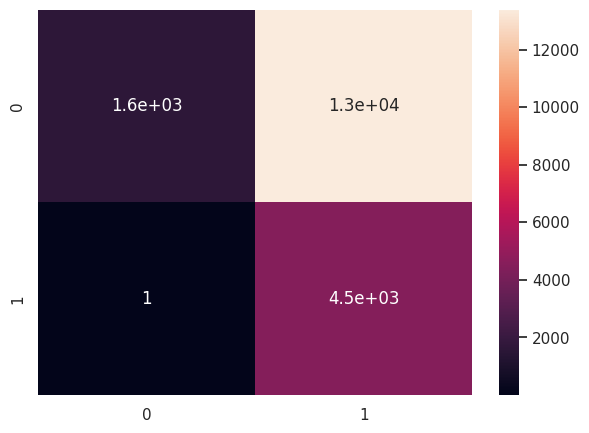

In [ ]:
sns.set(rc={"figure.figsize":(7, 5)})
sns.heatmap(conf_matrixes[np.where(encoder.categories_[0] == 'drama')[0][0]], annot=True)

From confusion matrix I see that for dramas the most common(actially nearly only present) mistake is when not dramas are classified as dramas and so recall of this class is very high but presicion is low.

<Axes: >

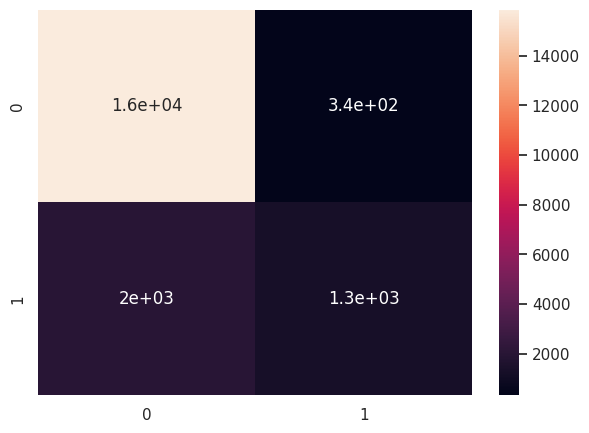

In [ ]:
sns.heatmap(conf_matrixes[np.where(encoder.categories_[0] == 'comedy')[0][0]], annot=True)

For comedies the most common mistake is false negative and so precision is higher then recall.

In [ ]:
pickle.dump(baseline_bayes, open('models/bayes', 'wb'))

## Logistic Regression

In [ ]:
log_reg = LogisticRegression(random_state=SEED)
linear_clf = train_evaluate(log_reg, X_train, X_test, y_train, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


model's train acc score = 0.5457343661827323
model's test acc score = 0.3910433979686057
model's train f1 score = 0.453790761407548
model's test f1 score = 0.30298565098560004


Logistic regression works much better and although it hasn't converged, the results are much better - 53% accuracy on train and 39 on test. perhaps there is sense in setting iterations to higher value

In [ ]:
log_reg_more_iter = LogisticRegression(random_state=SEED, max_iter=150)
train_evaluate(log_reg_more_iter, X_train, X_test, y_train, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


model's train acc score = 0.5460421689837377
model's test acc score = 0.3902739304401354
model's train f1 score = 0.45389726941492226
model's test f1 score = 0.3020652460347582


LogisticRegression(max_iter=150, random_state=12)

Increasing number of iterations hasn't increased the result so I'll stick to the default one

In [ ]:
print(classification_report(y_train, linear_clf.predict(X_train), target_names=encoder.categories_[0]))

                             precision    recall  f1-score   support

                       noir       1.00      0.04      0.08       259
                     action       0.67      0.61      0.64       841
           action adventure       0.00      0.00      0.00        25
              action comedy       0.00      0.00      0.00        94
               action crime       0.00      0.00      0.00        24
         action crime drama       0.00      0.00      0.00        26
action crime drama romantic       0.00      0.00      0.00         8
               action drama       0.00      0.00      0.00        89
             action fantasy       0.00      0.00      0.00        10
              action horror       0.00      0.00      0.00         9
              action masala       0.00      0.00      0.00        16
            action romantic       0.00      0.00      0.00        58
              action sci_fi       0.00      0.00      0.00        27
            action thriller      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic regression works much better because much more classes are present - not just 2 as in case of naive bayes although most classes are also not present here - macro f1 score is only 0.06. Interestingly, the best f1 score is not in most common classes, but in rather rare but specific like horror or western. Considering there is a great difference between train and test score, let's check out test report.

In [ ]:
print(classification_report(y_test, linear_clf.predict(X_test), target_names=encoder.categories_[0]))

                             precision    recall  f1-score   support

                       noir       0.00      0.00      0.00        86
                     action       0.35      0.27      0.30       280
           action adventure       0.00      0.00      0.00         9
              action comedy       0.00      0.00      0.00        32
               action crime       0.00      0.00      0.00         8
         action crime drama       0.00      0.00      0.00         9
action crime drama romantic       0.00      0.00      0.00         3
               action drama       0.00      0.00      0.00        30
             action fantasy       0.00      0.00      0.00         3
              action horror       0.00      0.00      0.00         3
              action masala       0.00      0.00      0.00         5
            action romantic       0.00      0.00      0.00        19
              action sci_fi       0.00      0.00      0.00         9
            action thriller      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
len(np.unique(linear_clf.predict(X_train)))

22

In [ ]:
len(np.unique(linear_clf.predict(X_test)))

17

Test result are simmilar to tran in terms of precision and recall but worse - the best classified classes are again drama, comedy, horror and western. also there is no big difference in classes presence - in both cases around 15% of classes are present.

For ensable models, i'll try bagging as it is natively multiclass, I think training boosting in ovr manner will take too much time.

In [ ]:
pickle.dump(linear_clf, open('models/log_reg', 'wb'))

## Random Forest

In [ ]:
forest = RandomForestClassifier(n_jobs=-1, random_state=SEED)
train_evaluate(forest, X_train, X_test, y_train, y_test)

model's train acc score = 0.9948186528497409
model's test acc score = 0.32779316712834716
model's train f1 score = 0.9948145723750224
model's test f1 score = 0.2347063581707205


RandomForestClassifier(n_jobs=-1, random_state=12)

I see there is a lot of overfitting so I'll try to do hyperparameters tuning later on

In [ ]:
len(np.unique(forest.predict(X_test)))

46

Number of classes is much higher then in case of logistic regression, which is a good sign.

In [ ]:
print(classification_report(y_test, forest.predict(X_test), target_names=encoder.categories_[0]))

                             precision    recall  f1-score   support

                       noir       0.50      0.01      0.02        86
                     action       0.44      0.09      0.14       280
           action adventure       0.00      0.00      0.00         9
              action comedy       0.00      0.00      0.00        32
               action crime       0.00      0.00      0.00         8
         action crime drama       0.00      0.00      0.00         9
action crime drama romantic       0.00      0.00      0.00         3
               action drama       0.00      0.00      0.00        30
             action fantasy       0.00      0.00      0.00         3
              action horror       0.00      0.00      0.00         3
              action masala       0.00      0.00      0.00         5
            action romantic       0.00      0.00      0.00        19
              action sci_fi       1.00      0.22      0.36         9
            action thriller      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


There are much more classes presented but in most cases the prediction are not very accurate - only westerns have f1 score higher then 0.5

## Boosting

In [ ]:
boosting = GradientBoostingClassifier(random_state=SEED, verbose=1, n_iter_no_change=5)
train_evaluate(boosting, X_train, X_test, y_train, y_test)

      Iter       Train Loss   Remaining Time 
         1           2.9067          677.44m
         2       64751.1913          667.46m


KeyboardInterrupt: ignored

Evaluated time is very big so I won't try boosting algorithms.

# Hyperparameters tuning

### optuna

In [ ]:
! pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.5 MB/s eta 0:00:00


In [16]:
import optuna
from sklearn.model_selection import cross_val_score

In [19]:
def objective_log_reg(trial):
    params = {'C': trial.suggest_float('C', 0, 5)}
    clf = LogisticRegression(random_state=SEED, **params)
    score = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=3, n_jobs=1).mean()
    return score


def objective_forest(trial):
    params = {'max_depth': trial.suggest_int('max_depth', 16, 256, 16),
              'min_samples_split': trial.suggest_float('min_samples_split', 0.00001, 0.01)
              }
    clf = RandomForestClassifier(random_state=SEED, n_jobs=-1, **params)
    score = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=3).mean()
    return score

I was unable to use optuna for log_reg as I don't have enough ram, for it I'll use random search.

In [ ]:
forest_study = tune_hyperparams_optuna(objective_forest, 20, 'f1')

[I 2023-07-19 17:09:49,613] A new study created in memory with name: no-name-d20c8bd4-ea75-4b82-af31-938bd4429db2


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-07-19 17:11:38,761] Trial 0 finished with value: 0.21395661888315778 and parameters: {'max_depth': 176, 'min_samples_split': 0.008677416685524346}. Best is trial 0 with value: 0.21395661888315778.
[I 2023-07-19 17:13:46,730] Trial 1 finished with value: 0.22148923710664636 and parameters: {'max_depth': 112, 'min_samples_split': 0.0030177882757179237}. Best is trial 1 with value: 0.22148923710664636.
[I 2023-07-19 17:14:14,442] Trial 2 finished with value: 0.11409340166564734 and parameters: {'max_depth': 16, 'min_samples_split': 0.004038484125666778}. Best is trial 1 with value: 0.22148923710664636.
[I 2023-07-19 17:17:54,221] Trial 3 finished with value: 0.22883734196954988 and parameters: {'max_depth': 128, 'min_samples_split': 0.00034520067828141366}. Best is trial 3 with value: 0.22883734196954988.
[I 2023-07-19 17:20:02,035] Trial 4 finished with value: 0.22195563128903273 and parameters: {'max_depth': 128, 'min_samples_split': 0.003729470251905469}. Best is trial 3 with v

In [ ]:
forest_tuned = train_evaluate(RandomForestClassifier(random_state=SEED, n_jobs=-1, **forest_study.best_params),
                              X_train, X_test, y_train, y_test)

model's train acc score = 0.9903042117683271
model's test acc score = 0.32717759310557093
model's train f1 score = 0.9902755119264223
model's test f1 score = 0.23255098755208825


Hyperparameters tuning has not given significant improvement for random forest.

### rand search for log_reg

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
from scipy.stats import norm

In [ ]:
params_dict = {
    'C': norm(loc=1, scale=1)  # Sampling 100 values uniformly from 0 to 10
}

tuned_log_reg = tune_hyperparams_rand(LogisticRegression(random_state=SEED), params_dict, X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ................................C=1.472985831489979; total time= 8.6min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ................................C=1.472985831489979; total time= 7.4min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ................................C=1.472985831489979; total time= 7.1min
[CV] END ...............................C=0.3185741205605549; total time= 6.1min
[CV] END ...............................C=0.3185741205605549; total time= 6.2min
[CV] END ...............................C=0.3185741205605549; total time= 5.9min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ................................C=1.242439496690478; total time= 7.0min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ................................C=1.242439496690478; total time= 7.0min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ................................C=1.242439496690478; total time= 7.1min
[CV] END ..............................C=-0.7007356340383315; total time=   0.0s
[CV] END ..............................C=-0.7007356340383315; total time=   0.0s
[CV] END ..............................C=-0.7007356340383315; total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...............................C=1.7531428339492003; total time= 6.9min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...............................C=1.7531428339492003; total time= 7.1min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...............................C=1.7531428339492003; total time= 7.0min
[CV] END ...............................C=-0.534721340208044; total time=   0.0s
[CV] END ...............................C=-0.534721340208044; total time=   0.0s
[CV] END ...............................C=-0.534721340208044; total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...............................C=1.0051270781322723; total time= 6.9min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...............................C=1.0051270781322723; total time= 6.9min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...............................C=1.0051270781322723; total time= 7.1min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...............................C=0.8797723298438087; total time= 7.1min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...............................C=0.8797723298438087; total time= 7.0min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...............................C=0.8797723298438087; total time= 7.1min
[CV] END ..............................C=0.19301812142704866; total time= 5.0min
[CV] END ..............................C=0.19301812142704866; total time= 5.1min
[CV] END ..............................C=0.19301812142704866; total time= 5.0min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...............................C=3.8718193949889166; total time= 7.0min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...............................C=3.8718193949889166; total time= 7.1min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...............................C=3.8718193949889166; total time= 7.0min


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
6 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1160, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/

Best hyperparameters: {'C': 3.8718193949889166}
Best f1 score: 0.3258939024998495


In [ ]:
pickle.dump(tuned_log_reg, open('models/tuned_log_reg', 'wb'))

In [ ]:
tuned_log_reg.score(X_train, y_train)

0.8408146514133279

In [ ]:
tuned_log_reg.score(X_test, y_test)

0.41089566020313945

# Conclusions

All in all, classification problem in multiclass variant appears to quite hard as there is a big overlap between classes and many classes are not presented enough to make accurate predictions. The best model is logistic regression with it's test accuracy = 0.41 and weighted f1 score = 0.325 after hyperparameters tuning.